<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>

---
# Training, Testing, and Validating CIFAR-10 in PyTorch
---

## Lesson plan

- Develop a convolutional neural network to classify CIFAR10  dataset
- Experiment with training and validation
- Use GPU to speed-up network training (*this notebook is very slow without access to a GPU*)
- Compute class-wise accuracy

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib

/home/conda/filesystem/438d9d1908d971c2b2a0f4b2cc683166d536833753f26b4a46bd996c613e5b77-20220604-044417-292940-71-cybera/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CIFAR10 data

- [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute For Advanced Research) collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton
- Contains 3-channel $32\times32$ pixel images
- Labelled with 10 classes
<center>
    <tr>
    <td><img src="images/cifar10.png" width="65%"></img></td>
    </tr>
</center>

In [2]:
# Use pathlib to point to pre-downloaded datasets
CIFAR_PATH = pathlib.Path('.') / 'data'

### Data processing

- We convert images to Torch Tensors
- We also normalize data to have 0 mean fall between -1 and 1.  

The normalize function below does the following for each channel:

$$
image = (image - mean) / std
$$

The parameters $mean$, $std$ are passed as 0.5, 0.5 in your case. This will normalize the image in the range $[-1,1]$. For example, the minimum value 0 will be converted to $(0-0.5)/0.5=-1$, the maximum value of 1 will be converted to $(1-0.5)/0.5=1.$

We can get our image back in $[0,1]$ range using

$$
image = ((image * std) + mean)
$$

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root=CIFAR_PATH, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=CIFAR_PATH, train=False, download=True, transform=transform)
print(f'Number of images in training set: {len(trainset)}')
print(f'Number of images in test set is: {len(testset)}')

170499072it [00:01, 95642031.71it/s]                                


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Number of images in training set: 50000
Number of images in test set is: 10000


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

## Setting up a convolutional neural network

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla K80


In [10]:
net = Net().to(device)

### Loss

In [11]:
criterion = nn.CrossEntropyLoss().to(device)

### Optimizer

In [12]:
import torch.optim as optim

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard for visualizing training performance

In [14]:
try:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummerWriter()
except:
    writer = None

In [15]:
datasets = {
    'train': trainset,
    'val': testset
}

dataloaders = {
    'train': trainloader,
    'val': testloader
}

In [16]:
starting_epoch = 0
num_epochs = 30

In [17]:
running_losses = {'train': [], 'val': []}
running_accs = {'train': [], 'val': []}

for epoch in range(starting_epoch, starting_epoch+num_epochs):
    
    running_loss = {'train': 0.0, 'val': 0.0}
    running_acc = {'train': 0.0, 'val': 0.0}
    
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train(True)
        else:
            net.train(False)
        
        running_loss = 0.0
        running_acc = 0.0
       
        for batch_i, samples in enumerate(dataloaders[phase]):
            images, labels = samples
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            error = criterion(outputs, labels)
            running_loss += error.item()
        
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
        
            # check out model.eval()
        
            if phase == 'train':
                optimizer.zero_grad()
                error.backward()
                optimizer.step()
        
        running_losses[phase].append( running_loss / len(datasets[phase]) )
        running_accs[phase].append( running_acc * 100.0 / len(datasets[phase]) )
    
    if writer:
        writer.add_scalar('Loss/train', running_losses['train'][-1], epoch)
        writer.add_scalar('Loss/validation', running_losses['val'][-1], epoch)
        writer.add_scalar('Accuracy/train', running_accs['train'][-1], epoch)
        writer.add_scalar('Accuracy/validation', running_accs['val'][-1], epoch)
        
    if epoch % 10 == 0:
        print('epoch={}, training err={:6.4}/acc={}, validation err={:6.4}/acc={}'.format(epoch, 
                                                                            running_losses['train'][-1], 
                                                                            running_accs['train'][-1],
                                                                            running_losses['val'][-1],
                                                                            running_accs['val'][-1]))
        
starting_epoch = epoch

epoch=0, training err=0.03568/acc=13.926, validation err=0.03456/acc=19.54
epoch=10, training err=0.02006/acc=54.22, validation err=0.02046/acc=53.02
epoch=20, training err=0.01619/acc=63.606, validation err=0.01721/acc=61.39


## Computing class-specific accuracy

In [18]:
%%time
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for k in range(len(data)):
            label = labels[k]
            class_correct[label] += c[k].item()
            class_total[label] += 1

CPU times: user 464 ms, sys: 168 ms, total: 632 ms
Wall time: 1.61 s


In [19]:
for i in range(10):
    print('Accuracy of {:5s} : {:4.1f}%'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84.0%
Accuracy of car   : 77.8%
Accuracy of bird  : 45.9%
Accuracy of cat   : 40.5%
Accuracy of deer  : 59.3%
Accuracy of dog   : 60.0%
Accuracy of frog  : 60.0%
Accuracy of horse : 71.0%
Accuracy of ship  : 64.5%
Accuracy of truck : 61.4%


Like with the MNIST dataset, we can use a confusion matrix to visualize our classifier's performance and build some intuition for where our model excels and where it struggles.

In [20]:
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:2d}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

The helper functions above are copy-pasted replicas of the ones in the MNIST notebook. Below, most of the code is also identical, with the exception of the use of the `classes` tuple defined at the top of this notebook to label the rows and columns of the confusion matrix for clearer interpretation.

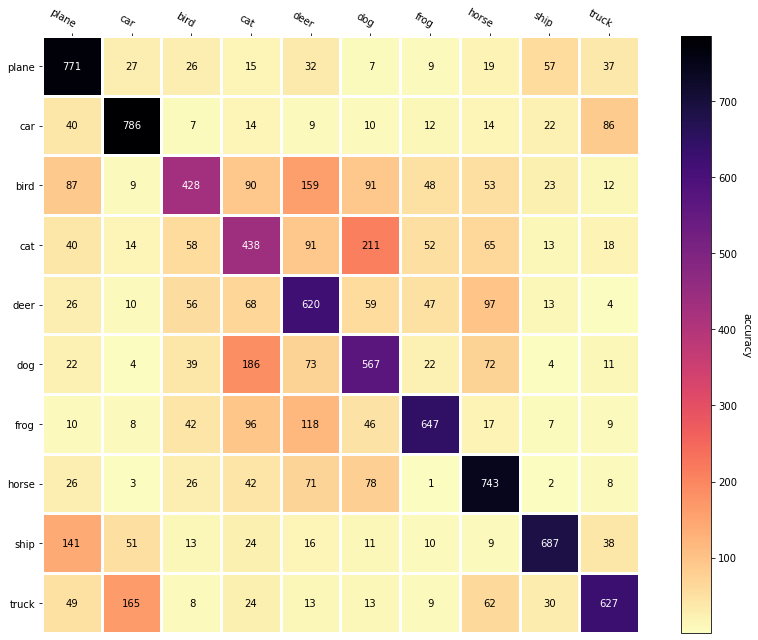

In [21]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        output = net(images) # Feed Network

        pred = torch.max(output, 1)[1].cpu().numpy()
        y_pred.extend(pred) # Save Prediction
        
        labels = labels.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize = (12, 9))

im, cbar = heatmap(cf_matrix, classes, classes, ax=ax,
                   cmap="magma_r", cbarlabel="accuracy")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()

<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>